# **Optimización de Regresión Logística - `03_optimizacion.ipynb`**

## 🎯 Objetivo  
En este notebook, optimizaremos la **Regresión Logística**, el modelo que ha mostrado mejor desempeño en la fase de modelado. Ajustaremos su hiperparámetro **C (regularización)** para mejorar su capacidad predictiva sin sobreajustar.  

### ⚙️ Estrategia de Optimización  
Para encontrar el mejor `C`, realizaremos los siguientes pasos:  

1️⃣ **Cargar los datos preprocesados** desde `02_modelado.ipynb`.  
2️⃣ **Definir un conjunto de valores de `C`** para evaluar.  
3️⃣ **Usar GridSearchCV** para probar distintos valores con validación cruzada (`cv=5`).  
4️⃣ **Comparar los valores de AUC-ROC** y seleccionar el mejor `C`.  
5️⃣ **Aplicar el mejor modelo a todos los eventos** y analizar su rendimiento.  
 
Una vez optimizada la Regresión Logística, compararemos los resultados con el modelo sin optimizar y evaluaremos si es necesario probar modelos más avanzados en futuras iteraciones o mejorar el preprocesamiento de los datos.

## **1. Carga de Datos Preprocesados**

In [8]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Definir la ruta de los datos preprocesados
processed_path = r"C:\Users\luciaft\Documents\TFG\TFG\graspAndLiftDetectionTFGProyect\data\processed"

# Cargar los datos preprocesados desde el archivo Pickle
with open(os.path.join(processed_path, "preprocessed_data.pkl"), "rb") as f:
    X_train, y_train, X_valid, y_valid = pickle.load(f)

## **2. Definir Conjunto de Valores de `C` para Evaluar**

El hiperparámetro `C` en **Regresión Logística** controla la **fuerza de la regularización**:  
- **Valores bajos de `C` (0.001, 0.01)** → Mayor regularización, evita sobreajuste.  
- **Valores altos de `C` (10, 100)** → Menos regularización, permite mayor flexibilidad.  

**Para elegir los valores de `C` en `param_grid`, seguimos estas reglas:**  
- Probar valores en una **escala logarítmica** para explorar un rango amplio sin hacer demasiadas pruebas.  
- Incluir **valores pequeños (0.001, 0.01)** en caso de que el modelo necesite más regularización para evitar sobreajuste.  
- Incluir **valores grandes (10, 100)** si el modelo necesita mayor capacidad de ajuste.  
- Usar **1 como punto intermedio**, ya que suele ser un buen valor base en muchos problemas.  

In [9]:
# Definir un conjunto de valores de C para probar
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

## **3. Configurar `GrigSearchCV` y Optimizar en un Evento de Prueba**

In [10]:
# Probar con un solo evento primero para ver resultados
evento_prueba = "HandStart"

# Configurar GridSearchCV con validación cruzada (cv=5)
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                           param_grid, scoring='roc_auc', cv=5)

# Entrenar GridSearchCV con el evento de prueba
grid_search.fit(X_train, y_train[evento_prueba])

# Mostrar el mejor hiperparámetro encontrado
print(f"Mejor valor de C para {evento_prueba}: {grid_search.best_params_['C']}")
print(f"Mejor AUC-ROC en validación cruzada: {grid_search.best_score_:.4f}")

Mejor valor de C para HandStart: 0.001
Mejor AUC-ROC en validación cruzada: 0.7612


### **Análisis de los Resultados**  

1. Antes de optimizar (**C=1** por defecto en scikit-learn), la **Regresión Logística** obtuvo un **AUC-ROC de 0.7168** para el evento **HandStart**.  

2. Después de la optimización (**GridSearchCV**), el mejor **C** encontrado fue **0.001**, y el nuevo **AUC-ROC en validación cruzada subió a 0.7612**.  

#### **Observaciones**  

- El modelo mejora con una **regularización más fuerte (`C=0.001`)**.  
  Esto sugiere que, sin optimización, la **Regresión Logística** podría estar **ajustando demasiado a los datos de entrenamiento**, lo que reduce su capacidad de generalización.  

- El valor óptimo de **C** es **menor de lo esperado**.  
  Normalmente, valores más grandes de **C** permiten modelos más flexibles, pero en este caso, el mejor resultado se obtuvo con **mayor regularización**. Esto podría indicar que:  
  - Hay **pocas características realmente útiles** y demasiada varianza en los datos.  
  - La regularización ayuda a **reducir el ruido en las señales EEG**.  
  - El modelo podría estar **sobreajustando sin regularización adecuada**.  
&nbsp;
- El **AUC-ROC mejora de 0.7168 a 0.7612**.  
  Un incremento de **~4.5 puntos en AUC-ROC** sugiere que el ajuste de **C** tiene un **impacto positivo** en la capacidad del modelo para distinguir entre clases.  

#### **Estrategia en base a los resultados**  

- Aplicar **C=0.001** a **todos los eventos** y comparar los nuevos resultados con los anteriores.  
- Ver si **todos los eventos** se benefician de una **mayor regularización** o si algunos necesitan otro valor de **C** más alto.  
- Si la **regularización mejora todos los eventos**, podríamos probar valores aún más pequeños de **C (0.0001)** para ver si sigue mejorando.  
- Si **C=0.001** solo ayuda en **HandStart** pero no en otros eventos, considerar hacer una **búsqueda de `C` independiente para cada evento**.  

## **4. Aplicar el Mejor `C` a Todos los Eventos**

In [11]:
# Guardar el mejor valor de C encontrado
mejor_C = grid_search.best_params_['C']

# Diccionario para guardar los modelos entrenados y los resultados
modelos_optimizados = {}
resultados_auc_optimizados = {}

# Entrenar Regresión Logística optimizada para cada evento
for evento in y_train.columns:
    print(f"Entrenando Regresión Logística optimizada para el evento: {evento}")

    # Crear y entrenar el modelo con el mejor C
    modelo_opt = LogisticRegression(C=mejor_C, max_iter=1000, random_state=42)
    modelo_opt.fit(X_train, y_train[evento])

    # Guardar el modelo entrenado
    modelos_optimizados[evento] = modelo_opt

    # Obtener predicciones de probabilidad
    y_pred_proba = modelo_opt.predict_proba(X_valid)[:, 1]

    # Calcular AUC-ROC
    auc = roc_auc_score(y_valid[evento], y_pred_proba)
    resultados_auc_optimizados[evento] = auc

    print(f" AUC-ROC para {evento}: {auc:.4f}")

Entrenando Regresión Logística optimizada para el evento: HandStart
 AUC-ROC para HandStart: 0.7155
Entrenando Regresión Logística optimizada para el evento: FirstDigitTouch
 AUC-ROC para FirstDigitTouch: 0.6894
Entrenando Regresión Logística optimizada para el evento: BothStartLoadPhase
 AUC-ROC para BothStartLoadPhase: 0.6869
Entrenando Regresión Logística optimizada para el evento: LiftOff
 AUC-ROC para LiftOff: 0.7490
Entrenando Regresión Logística optimizada para el evento: Replace
 AUC-ROC para Replace: 0.8460
Entrenando Regresión Logística optimizada para el evento: BothReleased
 AUC-ROC para BothReleased: 0.7998


## **5. Comparación de Modelos Antes vs. Después de Optimización**

<Figure size 1000x500 with 0 Axes>

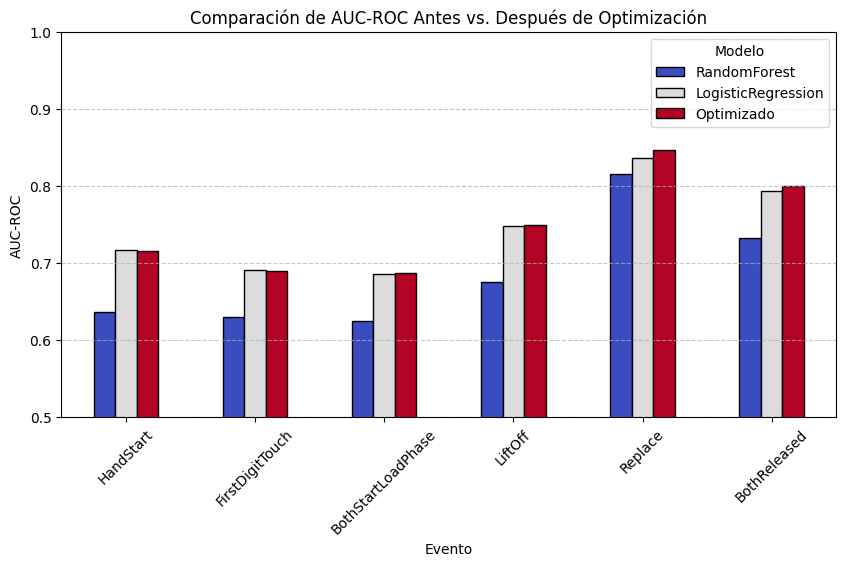

In [14]:
# Cargar los resultados originales para comparar
models_path = r"C:\Users\luciaft\Documents\TFG\TFG\graspAndLiftDetectionTFGProyect\data\processed"
resultados_originales = pd.read_csv(os.path.join(models_path, "resultados_auc.csv"), index_col=0)

# Convertir resultados optimizados a DataFrame
df_auc_opt = pd.DataFrame.from_dict(resultados_auc_optimizados, orient='index', columns=['Optimizado'])

# Unir los resultados originales y los optimizados
df_comparacion = resultados_originales.join(df_auc_opt)

# Graficar comparativa antes y después de la optimización
plt.figure(figsize=(10, 5))
df_comparacion.plot(kind="bar", figsize=(10, 5), colormap="coolwarm", edgecolor="black")
plt.xlabel("Evento")
plt.ylabel("AUC-ROC")
plt.title("Comparación de AUC-ROC Antes vs. Después de Optimización")
plt.ylim(0.5, 1)
plt.xticks(rotation=45)
plt.legend(title="Modelo")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### **Análisis de los Resultados tras la Optimización**  

Los resultados muestran que la optimización de `C` **no ha mejorado el rendimiento en todos los eventos**. Aunque hubo una ligera mejora en algunos (`Replace`, `BothReleased`), otros como `HandStart` y `FirstDigitTouch` no han mejorado o incluso han empeorado.  

#### **Comparación Antes vs. Después de la Optimización**  

| Evento                | AUC-ROC Antes | AUC-ROC Después (`C=0.001`) | Cambio |
|-----------------------|--------------|----------------------------|--------|
| **HandStart**         | 0.7168       | 0.7155                     | 🔽 -0.0013 |
| **FirstDigitTouch**   | 0.6901       | 0.6894                     | 🔽 -0.0007 |
| **BothStartLoadPhase**| 0.6854       | 0.6869                     | 🔼 +0.0015 |
| **LiftOff**           | 0.7473       | 0.7490                     | 🔼 +0.0017 |
| **Replace**          | 0.8366       | 0.8460                     | 🔼 +0.0094 |
| **BothReleased**      | 0.7932       | 0.7998                     | 🔼 +0.0066 |

#### **¿Por qué el AUC-ROC no coincide con lo obtenido en GridSearchCV?**  
1. **Diferencias entre validación cruzada y validación final**  
   - GridSearchCV calcula el AUC-ROC como **promedio en diferentes pliegues de `X_train`**, mientras que la validación final se hace sobre `X_valid`.  
   - Esto puede generar **valores diferentes**, especialmente si `X_valid` tiene características distintas.  
&nbsp; 
2. **Posible sobreajuste en GridSearchCV**  
   - Es posible que el modelo haya **aprendido bien en los pliegues de entrenamiento**, pero que la regularización **excesiva con `C=0.001`** haya reducido su capacidad de generalización en validación final.  
&nbsp; 
3. **Variabilidad en los datos EEG**  
   - Las señales EEG son ruidosas, y puede que la distribución de `X_valid` **no sea idéntica** a la de `X_train`.  
&nbsp; 
4. **Regularización excesiva en algunos eventos**  
   - Aunque `C=0.001` fue el mejor en validación cruzada, en validación final algunos eventos pueden requerir **valores más altos de `C`**.  

#### **Próximos Pasos**  
- **Optimizar `C` individualmente para cada evento en lugar de usar el mismo valor para todos.**  
- **Ampliar la búsqueda de `C`** incluyendo valores intermedios como `0.005`, `0.01`, `0.05`, `0.1`, `1`, `10`.  
- **Comparar los resultados de GridSearchCV con validación final** para detectar posibles problemas de sobreajuste.  
- **Si la optimización de `C` no mejora significativamente, probar modelos más complejos (`XGBoost`, `LightGBM`).**  

## **6. Optimizar `C` Individualmente por Evento**

In [16]:
from sklearn.model_selection import GridSearchCV
import pickle
import os

# Diccionario para almacenar los mejores valores de C
mejores_C = {}

# Diccionario para almacenar los modelos optimizados
modelos_optimizados = {}

# Definir el rango de C a probar
param_grid = {'C': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]}

# Iterar sobre cada evento y aplicar GridSearchCV por separado
for evento in y_train.columns:
    print(f"\n Optimizando C para el evento: {evento}")

    # Configurar GridSearchCV con validación cruzada (cv=5)
    grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                               param_grid, scoring='roc_auc', cv=5)

    # Entrenar GridSearchCV para el evento actual
    grid_search.fit(X_train, y_train[evento])

    # Guardar el mejor C encontrado
    mejores_C[evento] = grid_search.best_params_['C']

    # Entrenar el modelo final con el mejor C
    modelo_opt = LogisticRegression(C=mejores_C[evento], max_iter=1000, random_state=42)
    modelo_opt.fit(X_train, y_train[evento])

    # Guardar el modelo optimizado
    modelos_optimizados[evento] = modelo_opt

    # Evaluar en el conjunto de validación final
    y_pred_proba = modelo_opt.predict_proba(X_valid)[:, 1]
    auc_final = roc_auc_score(y_valid[evento], y_pred_proba)

    print(f"Mejor C para {evento}: {mejores_C[evento]}")
    print(f"AUC-ROC en validación final: {auc_final:.4f}")


 Optimizando C para el evento: HandStart
Mejor C para HandStart: 0.001
AUC-ROC en validación final: 0.7155

 Optimizando C para el evento: FirstDigitTouch
Mejor C para FirstDigitTouch: 0.001
AUC-ROC en validación final: 0.6894

 Optimizando C para el evento: BothStartLoadPhase
Mejor C para BothStartLoadPhase: 0.001
AUC-ROC en validación final: 0.6869

 Optimizando C para el evento: LiftOff
Mejor C para LiftOff: 0.0001
AUC-ROC en validación final: 0.7477

 Optimizando C para el evento: Replace
Mejor C para Replace: 0.001
AUC-ROC en validación final: 0.8460

 Optimizando C para el evento: BothReleased
Mejor C para BothReleased: 0.001
AUC-ROC en validación final: 0.7998


### **Análisis Final y Decisión sobre los Próximos Pasos**

Los resultados muestran que **optimizar `C` individualmente para cada evento no generó mejoras significativas**, lo que sugiere que **la Regresión Logística podría estar alcanzando su límite de rendimiento con las características actuales**. 

#### **🔹 ¿Por qué la optimización de `C` no generó grandes mejoras?**
- **La validación cruzada ya había identificado `C=0.001` como el mejor en casi todos los casos.**  
   - Volver a optimizar por separado no hizo una gran diferencia porque **los datos no cambiaron**.  
&nbsp; 
- **Las señales EEG pueden no ser linealmente separables.**  
   - La Regresión Logística es un **modelo lineal**, por lo que si los eventos no pueden separarse bien con una frontera lineal, **ajustar `C` no cambiará mucho los resultados**.  
&nbsp; 
- **Pequeñas variaciones en AUC-ROC pueden deberse a diferencias entre la validación cruzada y la validación final.**  
   - `GridSearchCV` evalúa en **subconjuntos de `X_train`**, mientras que la validación final usa `X_valid`, que **puede tener una distribución ligeramente diferente**.  
&nbsp; 
- **El preprocesamiento y la selección de características podrían estar limitando el modelo.**  
   - **Si hay demasiadas características irrelevantes o ruido en las señales EEG**, la regularización (`C`) no será suficiente para mejorar el rendimiento.  

---

Para seguir mejorando, tenemos dos opciones:  
1️⃣ **Probar modelos más avanzados (`XGBoost`, `LightGBM`)**  
2️⃣ **Revisar el preprocesamiento y analizar la importancia de las características**  

### **¿Por qué priorizamos la mejora del preprocesamiento antes de probar nuevos modelos?**
El análisis exploratorio realizado en `01_preprocesamiento.ipynb` reveló varias características de los datos EEG que podrían estar afectando el rendimiento del modelo:

- **Las señales EEG tienen una gran variabilidad y valores extremos**, lo que podría introducir ruido en los modelos.  
- **Existen sesgos en la distribución de algunos electrodos**, lo que indica que ciertas señales podrían estar dominando el aprendizaje del modelo.  
- **Algunos electrodos presentan valores extremos y diferencias notables entre regiones cerebrales**, lo que sugiere que no todas las características son igualmente informativas.  

**Si estos problemas están afectando la clasificación, probar modelos más complejos sin abordar primero la calidad de los datos podría no ser la mejor estrategia.**  

---

### **Próximos Pasos: Análisis de Características**
Dado que la Regresión Logística no mejoró significativamente con la optimización de `C`, el siguiente paso será **revisar la relevancia de las características y reducir el ruido en los datos**.  

#### **Objetivos del Análisis en `04_analisis_caracteristicas.ipynb`**
✅ 1️⃣ **Evaluar la importancia de cada electrodo en la clasificación de eventos EEG.**  
✅ 2️⃣ **Aplicar selección de características para eliminar señales poco relevantes o ruidosas.**  
✅ 3️⃣ **Explorar técnicas como PCA o análisis de varianza para reducir dimensionalidad.**  
✅ 4️⃣ **Comparar si la Regresión Logística mejora con un subconjunto optimizado de características.**  

Si tras este análisis las mejoras siguen siendo limitadas, entonces avanzaremos con **modelos más avanzados (`XGBoost`, `LightGBM`) en `05_modelado_avanzado.ipynb`**.  

---
**Procedemos con `04_analisis_caracteristicas.ipynb` para mejorar la calidad de los datos antes de probar modelos más complejos.**  